# JMH Benchmark Parser & Plotting Toolkit

This notebook provides:
1. A parser to extract datasets from JMH-style table output into typed arrays grouped by benchmark name.
2. Plotting helpers to compare **2, 3, 4, or 5** datasets on one chart.
3. A regression plotter that overlays a polynomial fit of configurable degree.

**Conventions**
- Parsed structure per benchmark: `List[Tuple[int, Tuple[float, float]]]` → `(size, (avg, error))`.
- `size` is taken from the filename part like `... 2_456chars.json ...` → `456`.
- Plot functions accept optional `output_folder` and `fmt` (`"svg"` or `"eps"`). If provided, figures are saved there.


In [45]:

# Imports (matplotlib only; seaborn intentionally not used)
from __future__ import annotations
import re
from typing import Dict, List, Tuple, Sequence, Iterable, Optional
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def _ensure_save(fig, filename: Optional[str|Path], fmt: str = "svg", output_folder: Optional[str|Path] = None):
    """Save `fig` if `output_folder` is provided. Returns output path or None."""
    if output_folder is None:
        return None
    fmt = (fmt or "svg").lower()
    if fmt not in {"svg", "eps", "pdf", "png"}:
        raise ValueError(f"Unsupported format: {fmt!r}. Use 'svg', 'eps', 'pdf', or 'png'.")
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    filename = Path(filename) if filename is not None else Path("figure")
    outpath = output_folder / (filename.stem + f".{fmt}")
    fig.savefig(outpath, format=fmt, bbox_inches="tight", dpi=300)
    return outpath


In [46]:

def parse_jmh_table(raw_text: str) -> Dict[str, List[Tuple[int, Tuple[float, float]]]]:
    """Parse JMH-like '[info] Benchmark ...' table lines into datasets.

    Returns a dict mapping benchmark name → list of (size, (avg, error)).
    The list is sorted by size. Lines that don't match the expected table pattern are ignored.

    Expected columns pattern (loose, handles variable spacing):
      [info] <BenchmarkName> <file> <mode> <cnt> <score> ± <error> <units>

    Size extraction rule:
      Take the integer *immediately before* the 'chars' token in the filename.
      E.g., '102_23677chars.json' → 23677 ; '2_456chars.json' → 456.
    """
    datasets: Dict[str, List[Tuple[int, Tuple[float, float]]]] = {}

    # Regex for the table line
    line_re = re.compile(
        r"^\[info\]\s+"                               # prefix
        r"(?P<bench>\S+)\s+"                           # benchmark name
        r"(?P<file>\S+)\s+"                            # filename token
        r"(?P<mode>\S+)\s+"                            # mode (e.g., avgt)
        r"(?P<cnt>\d+)\s+"                             # count
        r"(?P<score>\d+(?:\.\d+)?)\s+"               # score (avg)
        r"±\s+"
        r"(?P<error>\d+(?:\.\d+)?)\s+"               # error
        r"(?P<units>\S+)\s*$"                          # units
    )

    # Extract the size found right before 'chars' inside the file token
    size_re = re.compile(r"_(?P<size>\d+)chars\b", re.IGNORECASE)

    for line in raw_text.splitlines():
        m = line_re.match(line)
        if not m:
            continue

        bench = m.group("bench")
        filetok = m.group("file")
        score = float(m.group("score"))
        error = float(m.group("error"))

        sm = size_re.search(filetok)
        if not sm:
            # If pattern fails, try to fallback to the last integer run in the token
            # (keeps the parser resilient for edge cases).
            m2 = re.search(r"(\d+)(?=\D*$)", filetok)
            if not m2:
                continue
            size = int(m2.group(1))
        else:
            size = int(sm.group("size"))

        datasets.setdefault(bench, []).append((size, (score, error)))

    # Sort each dataset by size
    for k in list(datasets.keys()):
        datasets[k].sort(key=lambda t: t[0])

    return datasets


In [47]:

from matplotlib import colors

def _clean_filename(s: str) -> str:
    filename_clean = s.replace("\n", "_").replace(" ", "_").replace("/", "_").replace(":", "_").replace(",", "_").replace(".", "_").replace("(", "_").replace(")", "_")
    changed = True
    while changed:
        new_clean = filename_clean.replace("__", "_")
        changed = (new_clean != filename_clean)
        filename_clean = new_clean
    return filename_clean

def _prep_xy(series: List[Tuple[int, Tuple[float, float]]]):
    xs = [s for s, _ in series]
    ys = [v[0] for _, v in series]
    yerr = [v[1] for _, v in series]
    return np.array(xs), np.array(ys), np.array(yerr)

# A list of easily distinguishable colors for colorblind-safe plots
_COLOR_CYCLE = [
    "#007bff",  # blue
    "#ff7f00",  # orange
    "#000000",  # black
    "#ff47a6",  # pink
    "#bdbd1d",  # yellow
    "#006354",  # teal
]

def _plot_many(datasets: Sequence[Tuple[str, List[Tuple[int, Tuple[float, float]]]]], 
               pretty_data_labels: Optional[Dict[str, str]] = None,
               title: Optional[str] = None,
               show_title: bool = False,
               output_folder: Optional[str|Path] = None,
               fmt: str = "svg",
               time_unit: str = "µs",
               convert_data_from_micro_sec: bool = False,
               show_error_bars: bool = True,
               normalize_based_on: Optional[str] = None,
               filename: Optional[str|Path] = None):
    n = len(datasets)
    if n < 2 or n > 6:
        raise ValueError("_plot_many expects between 2 and 6 datasets.")
    
    factor = 1.0
    if convert_data_from_micro_sec:
        # We convert from µs to the desired time unit
        if time_unit == "ms":
            factor = 1e-3
        elif time_unit == "s":
            factor = 1e-6
        elif time_unit == "ns":
            factor = 1e3    
        elif time_unit == "µs":
            factor = 1.0
        else:
            raise ValueError(f"Unsupported time unit for conversion: {time_unit!r}. Use 'ns', 'µs', 'ms', or 's'.")

    if normalize_based_on is not None:
        # Find the reference dataset
        ref_dataset = None
        for label, series in datasets:
            if label == normalize_based_on:
                ref_dataset = series
                break
        if ref_dataset is None:
            raise ValueError(f"Could not find dataset with label {normalize_based_on!r} for normalization.")
        ref_ys = np.array([v[0] for _, v in ref_dataset])
        ref_ys = ref_ys * factor

    fig, ax = plt.subplots(figsize=(7, 5))
    index = 0
    for label, series in datasets:
        xs, ys, yerr = _prep_xy(series)
        ys = ys * factor
        yerr = yerr * factor
        if normalize_based_on is not None:
            ys = ys / ref_ys
            yerr = yerr / ref_ys
        if pretty_data_labels and label in pretty_data_labels:
            label = pretty_data_labels[label]
        if show_error_bars:
            ax.errorbar(xs, ys, yerr=yerr, marker='o', linestyle='', label=label, 
                    color=_COLOR_CYCLE[index % len(_COLOR_CYCLE)],
                    capsize=3)
        else:
            ax.plot(xs, ys, marker='o', linestyle='', label=label,
                    color=_COLOR_CYCLE[index % len(_COLOR_CYCLE)])
        index += 1
    ax.set_xlabel("Number of elements")
    ax.set_ylabel(f"Time ({time_unit})")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    if title and show_title:
        ax.set_title(title)
    ax.legend()

    filename_clean = _clean_filename((filename or (title or f"compare_{n}_datasets")))
    
    saved = _ensure_save(fig, filename_clean, fmt, output_folder)
    plt.show()
    return saved

def plot2(d1: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          d2: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          pretty_data_labels: Optional[Dict[str, str]] = None,
          title: Optional[str] = None,
          show_title: bool = False,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          show_error_bars: bool = True,
          normalize_based_on: Optional[str] = None,
          filename: Optional[str|Path] = None):
    """Plot 2 datasets on the same axes."""
    return _plot_many([d1, d2], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, show_error_bars=show_error_bars, normalize_based_on=normalize_based_on, filename=filename)

def plot3(d1, d2, d3, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          show_error_bars: bool = True,
          normalize_based_on: Optional[str] = None,
          filename: Optional[str|Path] = None):
    """Plot 3 datasets on the same axes."""
    return _plot_many([d1, d2, d3], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, show_error_bars=show_error_bars, normalize_based_on=normalize_based_on, filename=filename)

def plot4(d1, d2, d3, d4, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          show_error_bars: bool = True,
          normalize_based_on: Optional[str] = None,
          filename: Optional[str|Path] = None):
    """Plot 4 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, show_error_bars=show_error_bars, normalize_based_on=normalize_based_on, filename=filename)

def plot5(d1, d2, d3, d4, d5, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          show_error_bars: bool = True,
          normalize_based_on: Optional[str] = None,
          filename: Optional[str|Path] = None):
    """Plot 5 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4, d5], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, show_error_bars=show_error_bars, normalize_based_on=normalize_based_on, filename=filename)

def plot6(d1, d2, d3, d4, d5, d6, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          show_error_bars: bool = True,
          normalize_based_on: Optional[str] = None,
          filename: Optional[str|Path] = None):
    """Plot 6 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4, d5, d6], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, show_error_bars=show_error_bars, normalize_based_on=normalize_based_on, filename=filename)

In [48]:

def _print_poly(poly: np.poly1d):
    equation = ""
    degree = len(poly.coeffs) - 1
    for i, coeff in enumerate(poly.coeffs):
        power = degree - i
        coeff_abs = abs(coeff)
        if coeff < 0:
            equation += " - "
        else:
            if i > 0:
                equation += " + "
        if power == 0:
            equation += f"{coeff_abs:.4g}"
        elif power == 1:
            equation += f"{coeff_abs:.4g}*x"
        else:
            equation += f"{coeff_abs:.4g}*x^{power}"
    print(f"Polynomial function f(x) = {equation}")

def plot_with_regression(dataset: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
                         degree: int = 1,
                         title: Optional[str] = None,
                         color: Optional[str] = None,
                         pretty_data_labels: Optional[Dict[str, str]] = None,
                         output_folder: Optional[str|Path] = None,
                         fmt: str = "svg",
                         time_unit: str = "µs",
                         filename: Optional[str|Path] = None):
    """Plot a dataset with error bars and overlay a polynomial regression of given degree.

    Parameters
    ----------
    dataset : (name, series) where series is List[(size, (avg, error))].
    degree : polynomial degree (>= 0).
    title : optional str for the plot title.
    output_folder : optional path to save the plot.
    fmt : 'svg' or 'eps' (default: 'svg').
    filename : optional filename stem for saving.
    """
    if degree < 0:
        raise ValueError("degree must be >= 0")

    label, series = dataset
    xs, ys, yerr = _prep_xy(series)

    # Fit polynomial
    coeffs = np.polyfit(xs, ys, deg=degree)
    poly = np.poly1d(coeffs)

    # Smooth line over the observed range
    xfit = np.linspace(xs.min(), xs.max(), 500)
    yfit = poly(xfit)


    fig, ax = plt.subplots(figsize=(7, 5))
    if pretty_data_labels and label in pretty_data_labels:
            label = pretty_data_labels[label]
    ax.errorbar(xs, ys, yerr=yerr, marker='o', color=color, linestyle='--', label=f"{label}")
    ax.plot(xfit, yfit, label=f"Poly deg {degree}")
    ax.set_xlabel("Number of elements")
    ax.set_ylabel(f"Time ({time_unit})")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    ax.legend()
    if title:
        ax.set_title(title)

    filename_clean = _clean_filename((filename or (title or f"regression_deg{degree}_{label}")))

    saved = _ensure_save(fig, filename_clean, fmt, output_folder)
    plt.show()
    _print_poly(poly)
    return saved



### Usage
```python
raw = """<paste your JMH output here>"""
data = parse_jmh_table(raw)

# Example: build tuples for plotting
bench1 = "JsonLexerBenchmark.lex_ZipperMem"
bench2 = "JsonLexerBenchmark.separability_pred"
d1 = (bench1, data[bench1])
d2 = (bench2, data[bench2])

# Compare two datasets
plot2(d1, d2, title="Lex vs Separability", output_folder="plots", fmt="svg")

# Regression for one dataset
plot_with_regression(d2, degree=1, title="Separability: Linear Fit", output_folder="plots", fmt="svg")
```


# Hashmap Benchmarks on Large Sizes

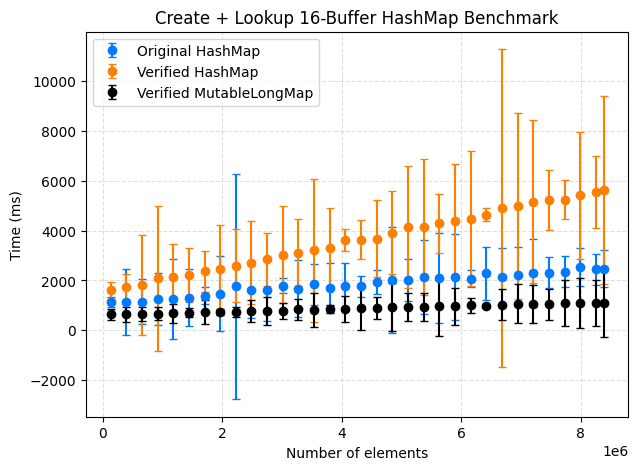

PosixPath('plots/hashmap_create_lookup_16buffer_comparison.svg')

In [49]:
latest_folder = Path("./latest")
hashmap_benchmark_file = None
for entry in os.listdir(latest_folder):
    if 'classtags' in entry.lower():
        hashmap_benchmark_file = latest_folder / entry
        break

createLookup_16Buffer_OriginalHashMap = "MutableHashMapBenchmarkBig.createUpdateLookup_16Buffer_OriginalHashMap"
createLookup_16Buffer_VerifiedHashMap = "MutableHashMapBenchmarkBig.createUpdateLookup_16Buffer_VerifiedHashMap"
createLookup_16Buffer_VerifiedMutableLongMap = "MutableHashMapBenchmarkBig.createUpdateLookup_16Buffer_VerifiedMutableLongMap"
createUpdateRemoveUpdateLookup_16Buffer_OriginalHashMap = "MutableHashMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_OriginalHashMap"
createUpdateRemoveUpdateLookup_16Buffer_VerifiedHashMap = "MutableHashMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_VerifiedHashMap"
createUpdateRemoveUpdateLookup_16Buffer_VerifiedMutableLongMap = "MutableHashMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_VerifiedMutableLongMap"
lookupN_OriginalHashMap = "MutableHashMapBenchmarkBig.lookupN_OriginalHashMap"
lookupN_VerifiedHashMap = "MutableHashMapBenchmarkBig.lookupN_VerifiedHashMap"
lookupN_VerifiedMutableLongMap = "MutableHashMapBenchmarkBig.lookupN_VerifiedMutableLongMap"


assert hashmap_benchmark_file is not None, "Could not find Hashmap lexer benchmark file in 'latest' folder."
with open(hashmap_benchmark_file, "r") as f:
    raw = f.read()
data = parse_jmh_table(raw)

d_createLookup_16Buffer_OriginalHashMap = (createLookup_16Buffer_OriginalHashMap, data[createLookup_16Buffer_OriginalHashMap])
d_createLookup_16Buffer_VerifiedHashMap = (createLookup_16Buffer_VerifiedHashMap, data[createLookup_16Buffer_VerifiedHashMap])
d_createLookup_16Buffer_VerifiedMutableLongMap = (createLookup_16Buffer_VerifiedMutableLongMap, data[createLookup_16Buffer_VerifiedMutableLongMap])
d_createUpdateRemoveUpdateLookup_16Buffer_OriginalHashMap = (createUpdateRemoveUpdateLookup_16Buffer_OriginalHashMap, data[createUpdateRemoveUpdateLookup_16Buffer_OriginalHashMap])
d_createUpdateRemoveUpdateLookup_16Buffer_VerifiedHashMap = (createUpdateRemoveUpdateLookup_16Buffer_VerifiedHashMap, data[createUpdateRemoveUpdateLookup_16Buffer_VerifiedHashMap])
d_createUpdateRemoveUpdateLookup_16Buffer_VerifiedMutableLongMap = (createUpdateRemoveUpdateLookup_16Buffer_VerifiedMutableLongMap, data[createUpdateRemoveUpdateLookup_16Buffer_VerifiedMutableLongMap])
d_lookupN_OriginalHashMap = (lookupN_OriginalHashMap, data[lookupN_OriginalHashMap])
d_lookupN_VerifiedHashMap = (lookupN_VerifiedHashMap, data[lookupN_VerifiedHashMap])
d_lookupN_VerifiedMutableLongMap = (lookupN_VerifiedMutableLongMap, data[lookupN_VerifiedMutableLongMap])

plot3(d_createLookup_16Buffer_OriginalHashMap,
      d_createLookup_16Buffer_VerifiedHashMap,
      d_createLookup_16Buffer_VerifiedMutableLongMap,
      title="Create + Lookup 16-Buffer HashMap Benchmark",
      show_title=True,
      pretty_data_labels={
          createLookup_16Buffer_OriginalHashMap: "Original HashMap",
          createLookup_16Buffer_VerifiedHashMap: "Verified HashMap",
          createLookup_16Buffer_VerifiedMutableLongMap: "Verified MutableLongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      filename="hashmap_create_lookup_16buffer_comparison")

# LongMap Benchmark Results

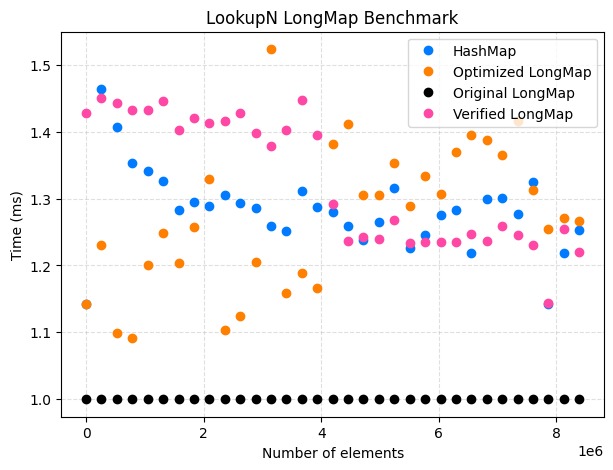

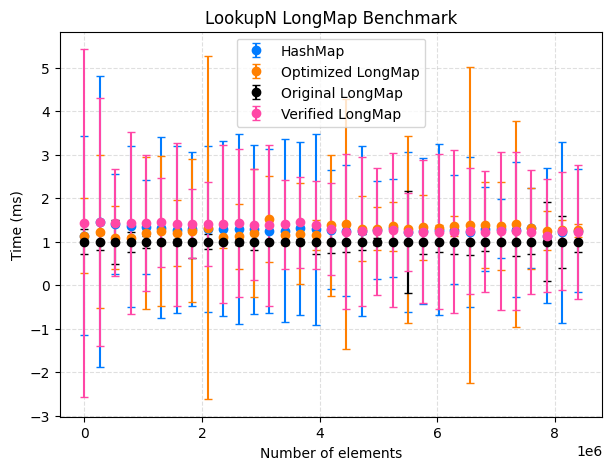

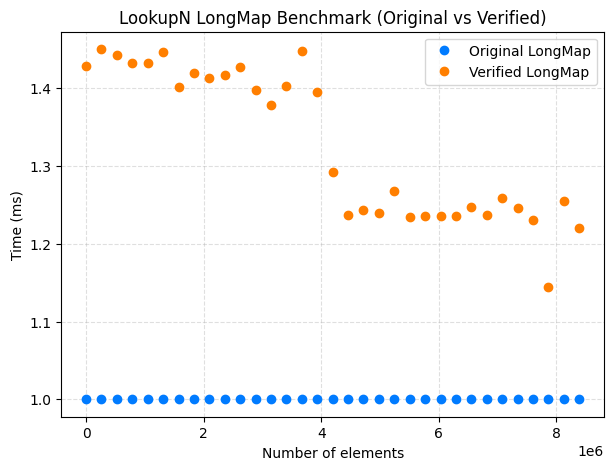

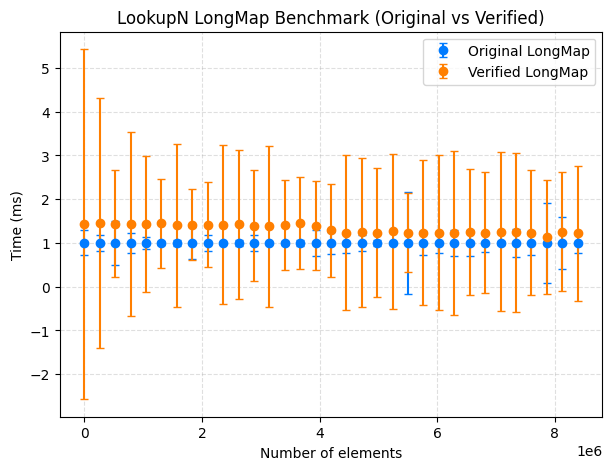

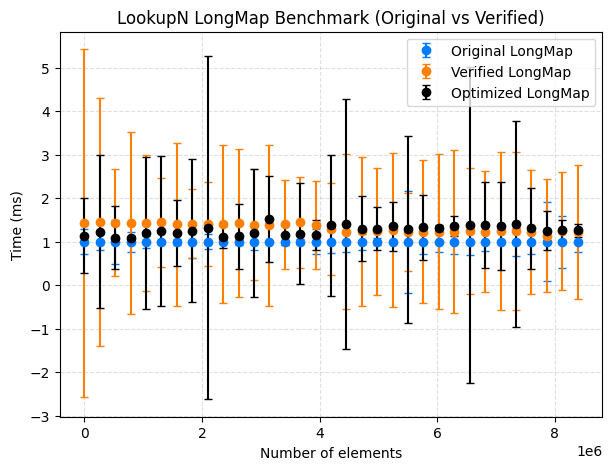

PosixPath('plots/longmap_lookupN_original_vs_verified.svg')

In [51]:
latest_folder = Path("./latest")
longmap_benchmark_file = None
for entry in os.listdir(latest_folder):
    if 'classtags' in entry.lower():
        longmap_benchmark_file = latest_folder / entry
        break
assert longmap_benchmark_file is not None, "Could not find LongMap lexer benchmark file in 'latest' folder."

with open(longmap_benchmark_file, "r") as f:
    raw2 = f.read()
data2 = parse_jmh_table(raw2)

lookupN_HashMap = "MutableLongMapBenchmarkBig.lookupN_HashMap"
lookupN_Opti = "MutableLongMapBenchmarkBig.lookupN_Opti"
lookupN_Original = "MutableLongMapBenchmarkBig.lookupN_Original"
lookupN_Verified = "MutableLongMapBenchmarkBig.lookupN_Verified"

d_lookupN_HashMap = (lookupN_HashMap, data2[lookupN_HashMap])
d_lookupN_Opti = (lookupN_Opti, data2[lookupN_Opti])
d_lookupN_Original = (lookupN_Original, data2[lookupN_Original])
d_lookupN_Verified = (lookupN_Verified, data2[lookupN_Verified])

plot4(d_lookupN_HashMap,
      d_lookupN_Opti,
      d_lookupN_Original,
      d_lookupN_Verified,
      title="LookupN LongMap Benchmark",
      show_title=True,
      pretty_data_labels={
          lookupN_HashMap: "HashMap",
          lookupN_Opti: "Optimized LongMap",
          lookupN_Original: "Original LongMap",
          lookupN_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      show_error_bars=False,
      normalize_based_on=lookupN_Original,
      filename="longmap_lookupN_comparison")

plot4(d_lookupN_HashMap,
      d_lookupN_Opti,
      d_lookupN_Original,
      d_lookupN_Verified,
      title="LookupN LongMap Benchmark",
      show_title=True,
      pretty_data_labels={
          lookupN_HashMap: "HashMap",
          lookupN_Opti: "Optimized LongMap",
          lookupN_Original: "Original LongMap",
          lookupN_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      show_error_bars=True,
      normalize_based_on=lookupN_Original,
      filename="longmap_lookupN_comparison")

plot2(d_lookupN_Original,
      d_lookupN_Verified,
      title="LookupN LongMap Benchmark (Original vs Verified)",
      show_title=True,
      pretty_data_labels={
          lookupN_Original: "Original LongMap",
          lookupN_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      show_error_bars=False,
      normalize_based_on=lookupN_Original,
      filename="longmap_lookupN_original_vs_verified")

plot2(d_lookupN_Original,
      d_lookupN_Verified,
      title="LookupN LongMap Benchmark (Original vs Verified)",
      show_title=True,
      pretty_data_labels={
          lookupN_Original: "Original LongMap",
          lookupN_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      show_error_bars=True,
      normalize_based_on=lookupN_Original,
      filename="longmap_lookupN_original_vs_verified")


plot3(d_lookupN_Original,
      d_lookupN_Verified,
      d_lookupN_Opti,
      title="LookupN LongMap Benchmark (Original vs Verified)",
      show_title=True,
      pretty_data_labels={
          lookupN_Original: "Original LongMap",
          lookupN_Verified: "Verified LongMap",
          lookupN_Opti: "Optimized LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      show_error_bars=True,
      normalize_based_on=lookupN_Original,
      filename="longmap_lookupN_original_vs_verified")

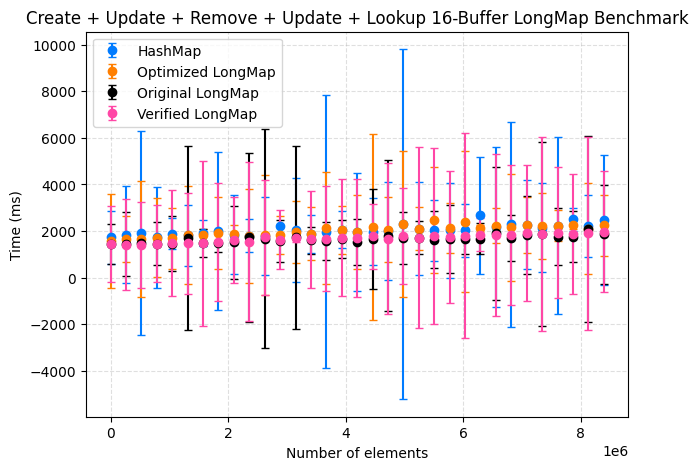

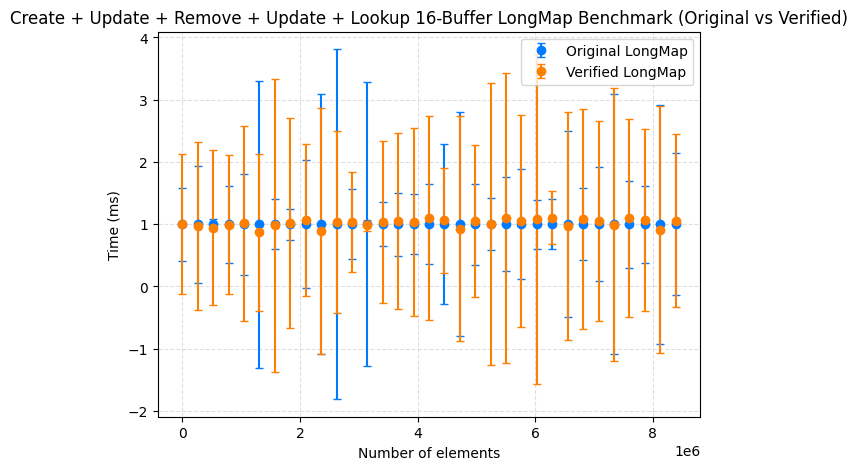

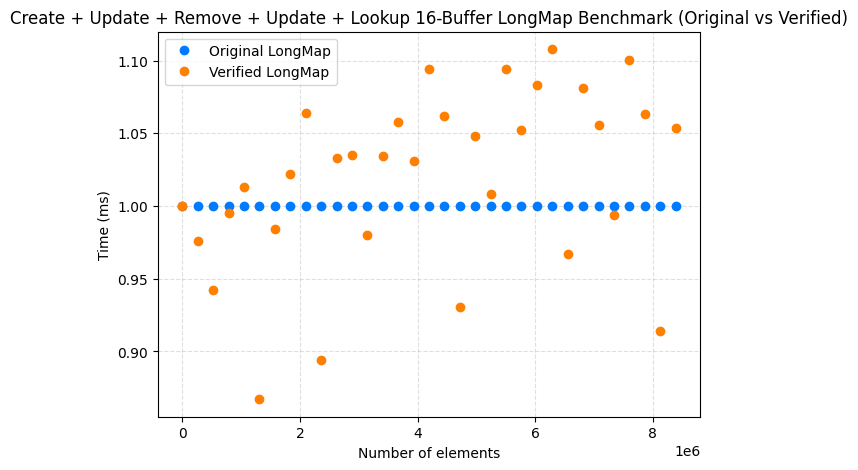

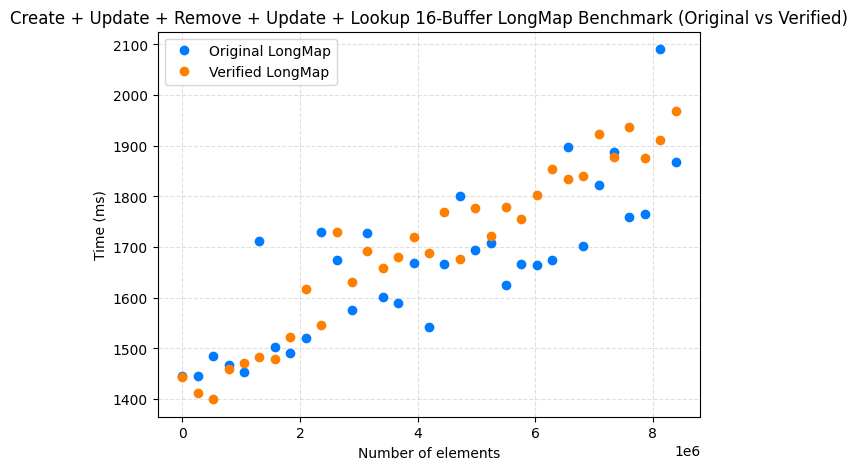

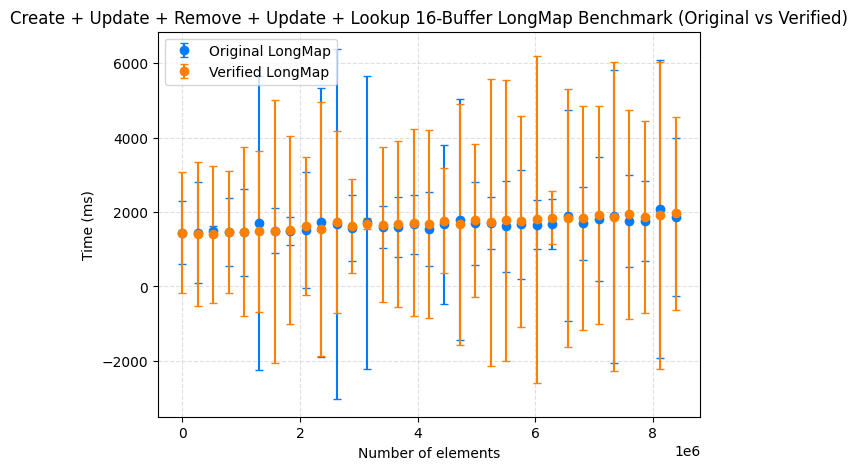

PosixPath('plots/longmap_create_update_remove_update_lookup_16buffer_original_vs_verified.svg')

In [58]:

createUpdateRemoveUpdateLookup_HashMap = "MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_HashMap"
createUpdateRemoveUpdateLookup_Opti = "MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Opti"
createUpdateRemoveUpdateLookup_Original = "MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Original"
createUpdateRemoveUpdateLookup_Verified = "MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer_Verified"

d_createUpdateRemoveUpdateLookup_HashMap = (createUpdateRemoveUpdateLookup_HashMap, data2[createUpdateRemoveUpdateLookup_HashMap])
d_createUpdateRemoveUpdateLookup_Opti = (createUpdateRemoveUpdateLookup_Opti, data2[createUpdateRemoveUpdateLookup_Opti])
d_createUpdateRemoveUpdateLookup_Original = (createUpdateRemoveUpdateLookup_Original, data2[createUpdateRemoveUpdateLookup_Original])
d_createUpdateRemoveUpdateLookup_Verified = (createUpdateRemoveUpdateLookup_Verified, data2[createUpdateRemoveUpdateLookup_Verified])

plot4(d_createUpdateRemoveUpdateLookup_HashMap,
      d_createUpdateRemoveUpdateLookup_Opti,
      d_createUpdateRemoveUpdateLookup_Original,
      d_createUpdateRemoveUpdateLookup_Verified,
      title="Create + Update + Remove + Update + Lookup 16-Buffer LongMap Benchmark",
      show_title=True,
      pretty_data_labels={
          createUpdateRemoveUpdateLookup_HashMap: "HashMap",
          createUpdateRemoveUpdateLookup_Opti: "Optimized LongMap",
          createUpdateRemoveUpdateLookup_Original: "Original LongMap",
          createUpdateRemoveUpdateLookup_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      filename="longmap_create_update_remove_update_lookup_16buffer_comparison")

plot2(d_createUpdateRemoveUpdateLookup_Original,
      d_createUpdateRemoveUpdateLookup_Verified,
      title="Create + Update + Remove + Update + Lookup 16-Buffer LongMap Benchmark (Original vs Verified)",
      show_title=True,
      pretty_data_labels={
          createUpdateRemoveUpdateLookup_Original: "Original LongMap",
          createUpdateRemoveUpdateLookup_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      normalize_based_on=createUpdateRemoveUpdateLookup_Original,
      filename="longmap_create_update_remove_update_lookup_16buffer_original_vs_verified")

plot2(d_createUpdateRemoveUpdateLookup_Original,
      d_createUpdateRemoveUpdateLookup_Verified,
      title="Create + Update + Remove + Update + Lookup 16-Buffer LongMap Benchmark (Original vs Verified)",
      show_title=True,
      pretty_data_labels={
          createUpdateRemoveUpdateLookup_Original: "Original LongMap",
          createUpdateRemoveUpdateLookup_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      show_error_bars=False,
      normalize_based_on=createUpdateRemoveUpdateLookup_Original,
      filename="longmap_create_update_remove_update_lookup_16buffer_original_vs_verified")

plot2(d_createUpdateRemoveUpdateLookup_Original,
      d_createUpdateRemoveUpdateLookup_Verified,
      title="Create + Update + Remove + Update + Lookup 16-Buffer LongMap Benchmark (Original vs Verified)",
      show_title=True,
      pretty_data_labels={
          createUpdateRemoveUpdateLookup_Original: "Original LongMap",
          createUpdateRemoveUpdateLookup_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      show_error_bars=False,
      filename="longmap_create_update_remove_update_lookup_16buffer_original_vs_verified")

plot2(d_createUpdateRemoveUpdateLookup_Original,
      d_createUpdateRemoveUpdateLookup_Verified,
      title="Create + Update + Remove + Update + Lookup 16-Buffer LongMap Benchmark (Original vs Verified)",
      show_title=True,
      pretty_data_labels={
          createUpdateRemoveUpdateLookup_Original: "Original LongMap",
          createUpdateRemoveUpdateLookup_Verified: "Verified LongMap",
      },
      output_folder="./plots",
      convert_data_from_micro_sec=True,
      time_unit="ms",
      show_error_bars=True,
      filename="longmap_create_update_remove_update_lookup_16buffer_original_vs_verified")